In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
# test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')

## EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

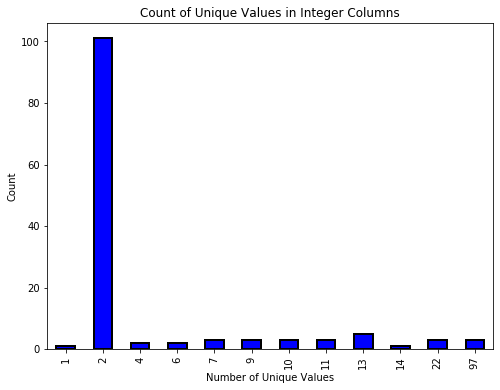

In [6]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(
                    color = 'blue',figsize = (8, 6),edgecolor = 'k', linewidth = 2)
plt.xlabel('Number of Unique Values'); plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

In [7]:
from collections import OrderedDict

# plt.figure(figsize = (20, 16))
# plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable',
                                                       4: 'non vulnerable'})

# # Iterate through the float columns
# for i, col in enumerate(train.select_dtypes('float')):
#     ax = plt.subplot(4, 2, i + 1)
#     # Iterate through the poverty levels
#     for poverty_level, color in colors.items():
#         # Plot each poverty level as a separate line
#         sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
#                     ax = ax, color = color, label = poverty_mapping[poverty_level])
        
#     plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

# plt.subplots_adjust(top = 2)

### Convert 'object' into 'float'

In [8]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [9]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


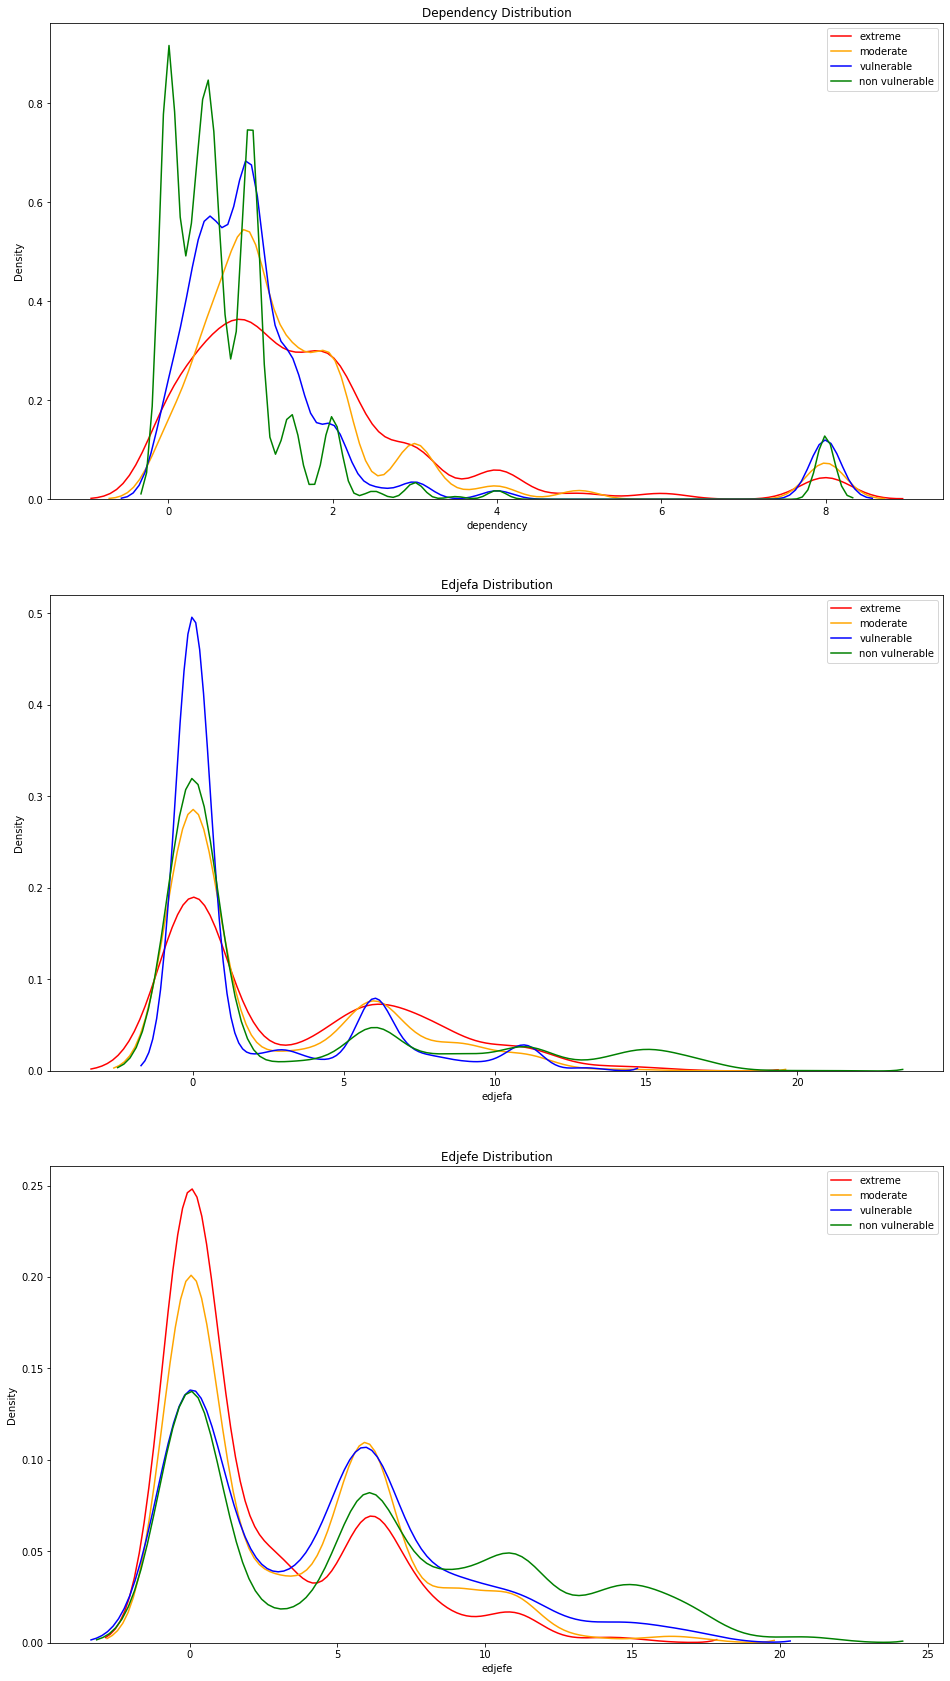

In [10]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}') 
    plt.ylabel('Density')

plt.subplots_adjust(top = 2)

### Combine training and testing data, so that we can apply the same operations to both data sets 

#### → we can separate them in the end based on the 'Target'

In [11]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

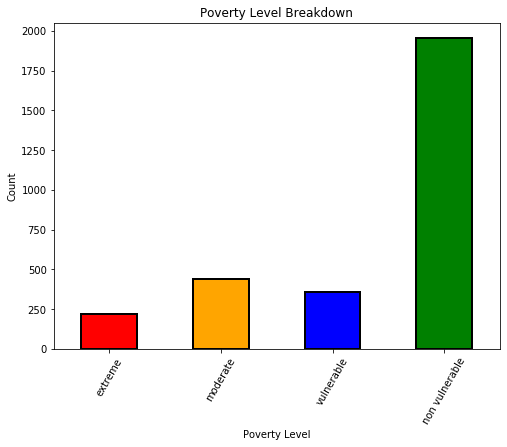

In [12]:
# Distribution of poverty level

heads = data.loc[data['parentesco1'] == 1].copy()

train_labels = data.loc[(data['Target'].notnull()) & 
                        (data['parentesco1'] == 1), ['Target', 'idhogar']]

label_counts = train_labels['Target'].value_counts().sort_index()
label_counts.plot.bar(figsize = (8, 6),color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

### Correct the label of every ID based on the head of household(parentesco1 == 1)

In [13]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print(
  'There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [14]:
# E.g.
train[train['idhogar'] == not_equal.index[2]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
2311,0511912b6,1,4
2312,0511912b6,0,4
2313,0511912b6,0,4
2314,0511912b6,0,3


In [15]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(
                                            households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [16]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(
                                                                    lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(
                                                        sum(households_no_head_equal == False)))

0 Households with no head have different labels.


In [17]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & 
                                        (train['parentesco1'] == 1.0)]['Target'])
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print(
 'There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


### Addressing the NaN in training and testing data

In [18]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [19]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

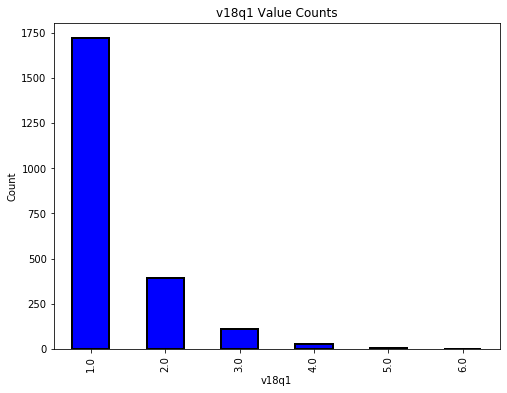

In [20]:
plot_value_counts(heads, 'v18q1')

In [21]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

<p style="color:blue">→ Due to this plot, we can figure out that the null values mean that the family does not own a tablet.

In [22]:
# Thus, we fill the NaN with zero
data['v18q1'] = data['v18q1'].fillna(0)

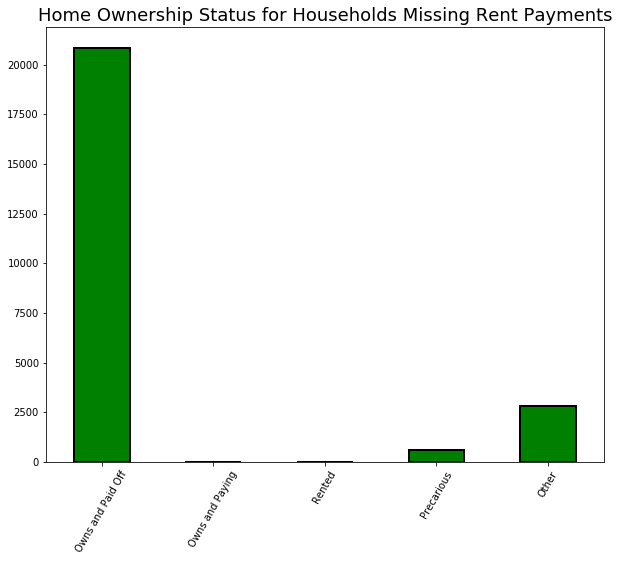

In [23]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                              color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

In [24]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [25]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [26]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

In [27]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

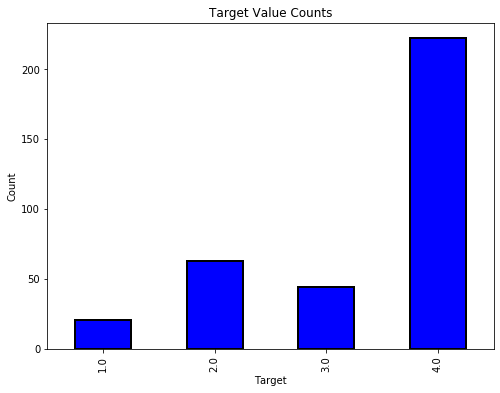

In [28]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 
                  'Target')

The distribution here seems to match that for all the data at large.

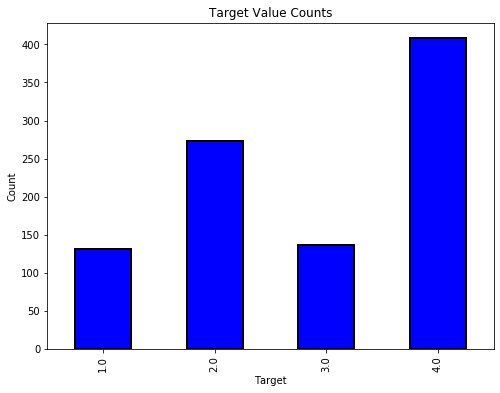

In [29]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 
                  'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty. 

__This represents an important point__: sometimes the missing information is just as important as the information you are given. 

### Organizing all variables of feature

→ grouping the individuals in a house and performing an aggregation of each variables.

In [30]:
id_ = ['Id', 'idhogar', 'Target']

In [31]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [32]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [33]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

#### Squared Variables

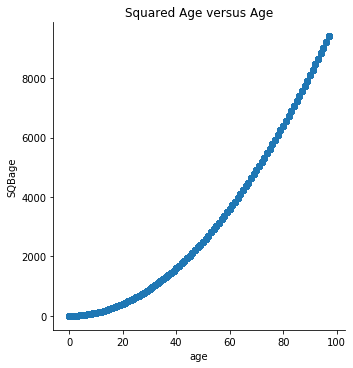

In [34]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

These variables are highly correlated, and we don't need to keep both in our data.

In [35]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

## ID and Household Level Variables

In [36]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

## Remove the redundant variables( with high correlatied variables)

In [37]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

These show one out of each pair of correlated variables. To find the other pair, we can subset the `corr_matrix`. 

In [38]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


In [39]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

/Users/leo/miniconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


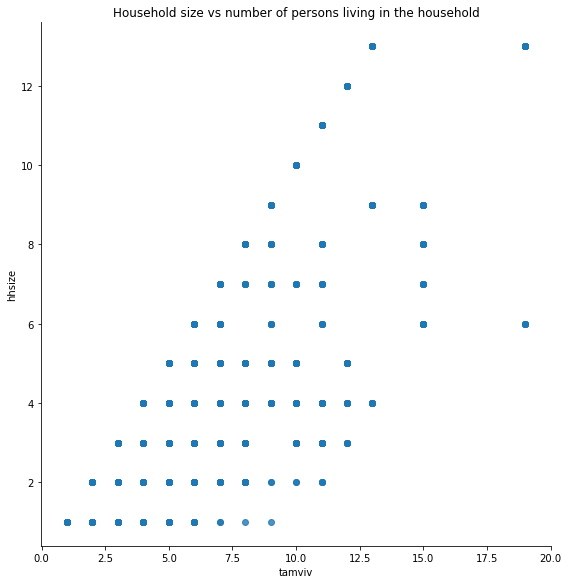

In [40]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

### Create a new feature: the difference between these two measurements

In [41]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

### Create a new feature: an ordinal variable to represent four similar variables

In [42]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


In [43]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

### Create a new feature: an ordinal variable with an inherent order(bad < regular < good)

In [44]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

In [45]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),axis = 1)

heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])

In [46]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

### Feature Construction for adding up the previous three features

In [47]:
# New feature for wall, roof and floor
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

In [48]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(
                normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


### Feature Construction: warning variable with negative value

In [49]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) + 
                        heads['pisonotiene'] + heads['abastaguano'] + 
                        (heads['cielorazo'] == 0))

### Feature Construction: bouns variable

In [50]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

### Per Capita Features

In [51]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

### Remove redundaant individual variables

In [52]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

In [53]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [54]:
ind = ind.drop(columns = 'male')  # This is simply the opposite of male!

### Create a new feature: an ordinal variable with the different amount of education an individual has

In [55]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [56]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

In [57]:
# Drop the education columns
ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 31)

### Feature Construction for individual variables

In [58]:
ind['escolari/age'] = ind['escolari'] / ind['age']

In [59]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

###  Combine the individual data with the household data by aggregating it for each household

In [60]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(
                                                        ['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...  inst/age  \
           min max sum count  std range_ min max sum count  ...       sum   
idhogar                                                     ...             
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...  0.483333   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...  0.016667   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...  0.511959   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...  0.184211   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...  0.213768   

                                    tech                            
          count       std    range_  min max sum count  std range_  
idhogar                                                             
000a08204     3  0.139775  0.250000    2   2   6     3  0.0      0  
000bce7c4     2  0.011785  0.016667    1   1   2     2  0.0      0  
001845fb0     4  0.060123  0.128205    1   1   4     4  0.0      0  
001ff74ca     1       NaN  0.000000    2   2   4     2  0.0      0  
003123ec2     4  0.064636  0.130435    1   1   4     4  0.0      0  

[5 rows x 180 columns]

In [61]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.184211,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.213768,4,0.064636,0.130435,1,1,4,4,0.0,0


In [62]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selection by removing one out of every pair of variables with a correlation greater than 0.95

In [63]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 85 correlated columns to remove.


In [64]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 190)


In [65]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


# Modeling

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [67]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

In [68]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

/Users/leo/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [69]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(
  f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.356 with std = 0.0527


### With feature Importances, we can easily realize the usefulness of features in the model.

In [70]:
model.fit(train_set, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000780
1,hacapo,0.000248
2,v14a,0.000324
3,refrig,0.001813
4,paredblolad,0.007214


## Model Selection

In [71]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [72]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [73]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.27958 with std: 0.0458


In [74]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.18623 with std: 0.04288


In [75]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.31154 with std: 0.0642


In [76]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.30919 with std: 0.05934


In [77]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27882 with std: 0.03409


In [78]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.32589 with std: 0.02495

KNN with 10 neighbors

10 Fold CV Score: 0.30143 with std: 0.04147

KNN with 20 neighbors

10 Fold CV Score: 0.26638 with std: 0.02634


In [79]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.31985 with std: 0.05438


## Comparing Model Performance

In [80]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.35604 with std: 0.05268


In [81]:
# model_results

In [82]:
df_model_compare = pd.DataFrame()
df_model_compare['score'] = model_results.cv_mean
df_model_compare.index = model_results.model
df_model_compare.sort_values(by=['score'],ascending=False)

,score
model,
RF,0.356044
knn-5,0.325889
EXT,0.319846
MLP,0.311536
LDA,0.309194
knn-10,0.301434
LSVC,0.279575
RIDGE,0.278816
knn-20,0.266384


### Submit the temporary result so far

In [83]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [84]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [85]:
submission_test = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         train_set, train_labels, test_set, test_ids)

submission_test.to_csv('submission.csv', index = False)